# Compare data sets

Compare the "old" and "new" datasets for Chicago.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle
import pyproj

# Read and process

Read the "old" and "new" files in, extract the fields we want, and save out as compressed csv files.

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
os.listdir(data_dir)
file_old = os.path.join(data_dir, "chicago_all_old.csv")
file_new = os.path.join(data_dir, "chicago_all.csv.xz")

In [3]:
with open(file_old, encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
header

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [4]:
wanted_fields = ["ID", "Case Number", "Date", "Block", "Primary Type",
                 "Description", "Location Description", "Latitude", "Longitude"]
wanted_fields = [header.index(x) for x in wanted_fields]

In [5]:
data_old = []
with open(file_old, encoding="utf8") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        data_old.append( [line[x] for x in wanted_fields] )
len(data_old)

5536001

In [6]:
data_new = []
with lzma.open(file_new, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        data_new.append( [line[x] for x in wanted_fields] )
len(data_new)

6328595

In [16]:
with bz2.open("old.csv.bz2", "wt") as f:
    writer = csv.writer(f)
    writer.writerows(data_old)

In [18]:
with bz2.open("new.csv.bz2", "wt") as f:
    writer = csv.writer(f)
    writer.writerows(data_new)

# Compare IDs

Does the field "id" compare with "Case Number" in both datasets?

- Each "id" numbers corresponds to exactly one "Case Number", and there is _nearly_ a match between old and new.

In [9]:
old = collections.defaultdict(list)
with bz2.open("old.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    for row in reader:
        old[row[0]].append(row[1])
        
new = collections.defaultdict(list)
with bz2.open("new.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    for row in reader:
        new[row[0]].append(row[1])

In [21]:
# Each case number is unique
for key, li in old.items():
    assert len(li) == len(set(li))
    assert len(li) == 1
for key, li in new.items():
    assert len(li) == len(set(li))
    assert len(li) == 1

In [15]:
missing = []
different = []

for key in old:
    if key in new:
        if set(old[key]) != set(new[key]):
            different.append(key)
    else:
        missing.append(key)

In [16]:
len(missing), len(different)

(1961, 66)

# Compare Case Numbers

- These are repeated
- But the repeats are almost all "HOMICIDE"

In [22]:
with bz2.open("old.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    old = [row[1] for row in reader]

with bz2.open("new.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    new = [row[1] for row in reader]

In [29]:
missing = set(old)
missing.difference_update(new)
len(missing)

1955

In [34]:
old = collections.defaultdict(list)
with bz2.open("old.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    for row in reader:
        old[ row[1] ].append(row)

In [36]:
doubles = []
for key in old:
    if len(old[key]) > 1:
        doubles.append( old[key] )

In [37]:
doubles[-1]

[['651',
  'G023235',
  '01/11/2001 09:10:00 PM',
  '101XX S LASALLE ST',
  'HOMICIDE',
  'FIRST DEGREE MURDER',
  'STREET',
  '41.710275073586',
  '-87.62734206017765'],
 ['650',
  'G023235',
  '01/11/2001 06:46:00 PM',
  '101XX S LASALLE ST',
  'HOMICIDE',
  'FIRST DEGREE MURDER',
  'STREET',
  '41.710275073586',
  '-87.62734206017765']]

# Compare

Compare by ID, and ignore "HOMICIDE" cases

- We expect the locations to be different...
- There are _small_ numbers of differences in the fields "Case Number", "Date", "Block" and "Location Description"
- And these seem to not overlap
- There are a large number of differences in "Primary Type" and "Description"
- But these differences seem reasonable

In [2]:
data = dict()
with bz2.open("old.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    for row in reader:
        if row[4] == "HOMICIDE":
            continue
        data[row[0]] = row[1:]
    
with bz2.open("new.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] in data:
            data[row[0]] = data[row[0]] + row[1:]

In [3]:
# Remove rows where we don't have a match in both input files.
for key in set(data.keys()):
    if len(data[key]) < 16:
        del data[key]

In [4]:
for i, name in enumerate(["Case Number", "Date", "Block", "Primary Type",
                 "Description", "Location Description"]):
    diffs = []
    for key, row in data.items():
        if row[i] != row[i+8]:
            diffs.append(key)
    print(name, len(diffs))

Case Number 65
Date 71
Block 44
Primary Type 11424
Description 433266
Location Description 74


In [5]:
# Any of Case, date, block, location different
diffs = []
for i, name in zip([0,1,2,5], ["Case Number", "Date", "Block", "Location Description"]):
    for key, row in data.items():
        if row[i] != row[i+8]:
            diffs.append(key)
len(diffs)

254

In [6]:
# Drop these
for key in diffs:
    if key in data:
        del data[key]
        
# Convert to a list
data = list(data.values())

### Join the spatial locations

- Check that all the address strings now match
- Drop any row which has a null location in either the old or new data
- Then extract the address string, and project to coordinates using http://spatialreference.org/ref/epsg/3528/
- Save using numpy and `lzma` and save the raw data as a compress csv file.

In [7]:
assert sum( row[2] != row[10] for row in data ) == 0
data = [row for row in data if not (row[6] == "" or row[14] == "")]

In [8]:
# Project using 
proj = pyproj.Proj({"init":"epsg:3528"})
old_coords = []
new_coords = []
addresses = []
for row in data:
    old_coords.append( proj(row[7], row[6]) )
    new_coords.append( proj(row[15], row[14]) )
    addresses.append( row[2] )

In [9]:
old_coords = np.asarray(old_coords)
new_coords = np.asarray(new_coords)
addresses = np.asarray(addresses)
old_coords.shape, new_coords.shape, addresses.shape

((5480314, 2), (5480314, 2), (5480314,))

In [10]:
with lzma.open("old_coords.np.xz", "wb") as f:
    np.save(f, old_coords, allow_pickle=False)
with lzma.open("new_coords.np.xz", "wb") as f:
    np.save(f, new_coords, allow_pickle=False)
with lzma.open("addresses.np.xz", "wb") as f:
    np.save(f, addresses, allow_pickle=False)
with lzma.open("raw_data.csv.xz", "wt", encoding="utf8") as f:
    writer = csv.writer(f)
    writer.writerows(data)

# Compare spatial locations

If we compare the distance between be old and new location, we find three classes:
- 5-10% of rather close locations
- A very large number of "nearby" locations
- A small number of rather large jumps

Of the "nerby" locations, there are a few "very close" (order of a meter, not order numerical error) and a long tail which has no natural break...

In [2]:
with lzma.open("old_coords.np.xz", "rb") as f:
    old = np.load(f)
with lzma.open("new_coords.np.xz", "rb") as f:
    new = np.load(f)
with lzma.open("addresses.np.xz", "rb") as f:
    addresses = np.load(f)
with lzma.open("raw_data.csv.xz", "rt", encoding="utf8") as f:
    data = list( csv.reader(f) )

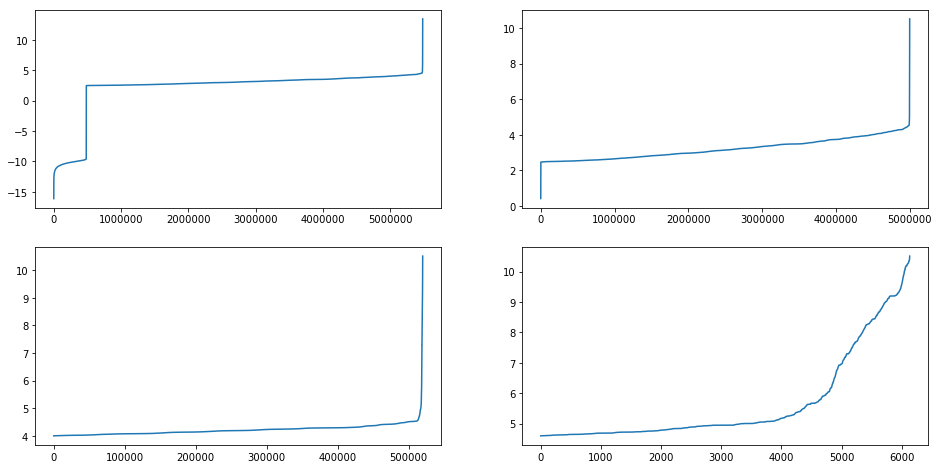

In [3]:
raw_dists = np.log(np.sum(((old - new)**2), axis=1)) / 2
distances = np.sort(raw_dists)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
ax[0][0].plot(distances)
ax[0][1].plot(distances[(distances > 0) & (distances < 11)])
ax[1][0].plot(distances[(distances > 4) & (distances < 11)])
ax[1][1].plot(distances[(distances > 4.6) & (distances < 11)])
None

In [4]:
# The natural break of small differences
max(distances[distances<-2]), min(distances[distances>=-2])

(-9.5774099499363228, 0.42130112119012336)

In [5]:
# The natural break of large differences
max(distances[distances<11]), min(distances[distances>=11])

(10.509148022718506, 13.402026495708496)

## Understand the big jumps

It turns out the "really big jumps" are all caused by junk data: the longitude / latitude coordinates in the "new" data now codes to a constant location which is not (even close to being) in Chicago.

In [8]:
proj = pyproj.Proj({"init":"epsg:3528"})

for row, want in zip(data, (raw_dists > 11)):
    if want:
        assert row[14] == '36.619446395'
        assert row[15] == '-91.686565684'

## Explore the very small jumps

Turns out that the 2001 data is geocoded (up to numerical error) the same in both datasets...

In [54]:
import datetime
times = [datetime.datetime.strptime(row[1], "%m/%d/%Y %I:%M:%S %p") for row in data]

In [55]:
max(t for t, want in zip(times, raw_dists<0) if want)

datetime.datetime(2001, 12, 31, 23, 58)

In [56]:
min(t for t, want in zip(times, raw_dists>0) if want)

datetime.datetime(2002, 1, 1, 0, 0)

## Visualise

Not clear to me that the geocoding is quite "accurate" but it's clearly different to the post-2001 "new" dataset.

In [10]:
import tilemapbase
import matplotlib.collections

In [11]:
proj = pyproj.Proj({"init":"epsg:3528"})

In [16]:
old_lon, old_lat = proj(old[:,0], old[:,1], inverse=True)
new_lon, new_lat = proj(new[:,0], new[:,1], inverse=True)
m = raw_dists < 0
old_lon, old_lat = old_lon[m], old_lat[m]
new_lon, new_lat = new_lon[m], new_lat[m]

In [29]:
xx, yy = [], []
for x, y in zip(old_lon, old_lat):
    x, y = tilemapbase.project(x, y)
    xx.append(x)
    yy.append(y)

In [17]:
lon_min = min(np.min(old_lon), np.min(new_lon))
lon_max = max(np.max(old_lon), np.max(new_lon))
lon_d = (lon_max - lon_min) * 0.01
lat_min = min(np.min(old_lat), np.min(new_lat))
lat_max = max(np.max(old_lat), np.max(new_lat))
lat_d = (lat_max - lat_min) * 0.01

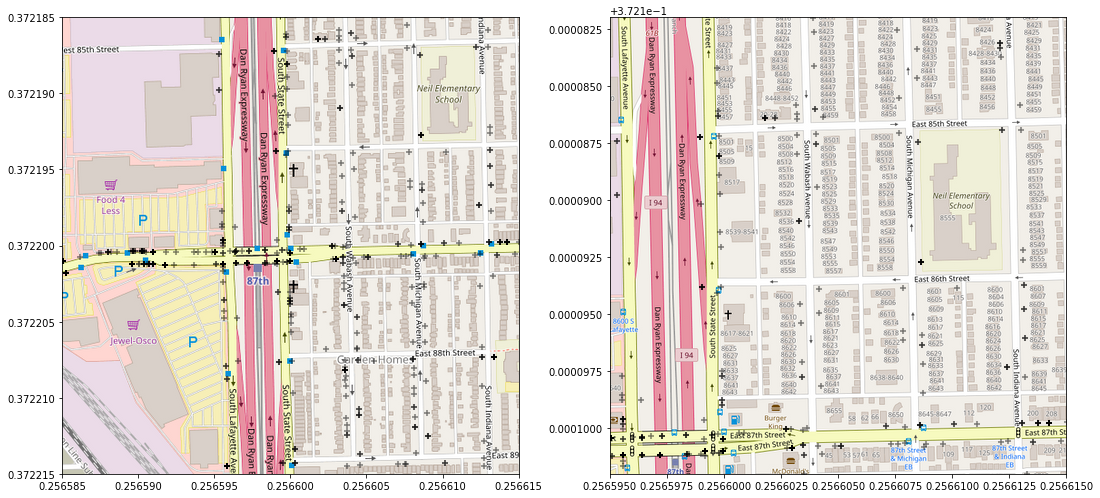

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

ex = tilemapbase.Extent.from_centre(0.2566, 0.3722, xsize=0.00003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[0])
ax[0].scatter(xx, yy, marker="+", color="black", alpha=0.5)

ex = tilemapbase.Extent.from_centre(0.256605, 0.372192, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[1])
ax[1].scatter(xx, yy, marker="+", color="black", alpha=0.5)

None

For easier browsing, let's convert to a GeoPandas dataframe and save so we can load into QGIS

In [47]:
import shapely.geometry
want_data = [row for row, want in zip(data, raw_dists<0) if want]
frame = gpd.GeoDataFrame.from_dict({
    "code" : [row[0] for row in want_data],
    "time" : [row[1] for row in want_data],
    "address" : [row[2] for row in want_data],
    "crime" : [row[3] for row in want_data],
    "sub-crime" : [row[4] for row in want_data],
    "location" : [row[5] for row in want_data],
})
geo = []
for row in want_data:
    x, y = float(row[7]), float(row[6])
    geo.append( shapely.geometry.Point(x, y) )
frame.geometry = geo
frame.crs = {"init":"epsg:4326"}
frame.head()

address      code            crime location  \
0      0000X N OGDEN AV  HH100082            THEFT   STREET   
1    022XX S LEAVITT ST  HH100067          BATTERY   STREET   
2  032XX W FULLERTON AV  HH100166          BATTERY   STREET   
3    047XX S HALSTED ST  HH100019  CRIMINAL DAMAGE   STREET   
4    043XX S PULASKI RD  HH100172  CRIMINAL DAMAGE   STREET   

                        sub-crime                    time  \
0                       OVER $300  12/31/2001 11:58:00 PM   
1  AGGRAVATED:KNIFE/CUTTING INSTR  12/31/2001 11:55:00 PM   
2             AGGRAVATED: HANDGUN  12/31/2001 11:55:00 PM   
3                     TO PROPERTY  12/31/2001 11:55:00 PM   
4                      TO VEHICLE  12/31/2001 11:55:00 PM   

                                       geometry  
0   POINT (-87.66584677912741 41.8818638199435)  
1   POINT (-87.6805965031314 41.85205271841248)  
2  POINT (-87.70765406401284 41.92482148397675)  
3    POINT (-87.645683301538 41.80881338792019)  
4  POINT (-87.72400558112507 41.81510086401971)

In [48]:
frame.to_file("no_change")

# Visualise the rest

In [2]:
import tilemapbase
import matplotlib.collections

In [3]:
with lzma.open("old_coords.np.xz", "rb") as f:
    old = np.load(f)
with lzma.open("new_coords.np.xz", "rb") as f:
    new = np.load(f)
with lzma.open("addresses.np.xz", "rb") as f:
    addresses = np.load(f)
with lzma.open("raw_data.csv.xz", "rt", encoding="utf8") as f:
    data = list( csv.reader(f) )

In [4]:
raw_dists = np.log(np.sum(((old - new)**2), axis=1)) / 2
mask = (raw_dists > 0) & (raw_dists < 11)
old = old[mask]
new = new[mask]
addresses = addresses[mask]
data = [row for row, want in zip(data, mask) if want]
raw_dists = raw_dists[mask]

proj = pyproj.Proj({"init":"epsg:3528"})
old_lon, old_lat = proj(old[:,0], old[:,1], inverse=True)
new_lon, new_lat = proj(new[:,0], new[:,1], inverse=True)

In [5]:
lon_min = min(np.min(old_lon), np.min(new_lon))
lon_max = max(np.max(old_lon), np.max(new_lon))
lon_d = (lon_max - lon_min) * 0.01
lat_min = min(np.min(old_lat), np.min(new_lat))
lat_max = max(np.max(old_lat), np.max(new_lat))
lat_d = (lat_max - lat_min) * 0.01

## Visualise the larger jumps

- Some appear to be obvious "errors" (Just geo-coding errors: the old coordinates just don't correspond to the stated block-level address, while the new coordinates do).
- The "larger" jumps appear to be a mixture of errors and areas of very low density (see right hand plot) where a large movement is necessary to give enough privacy.

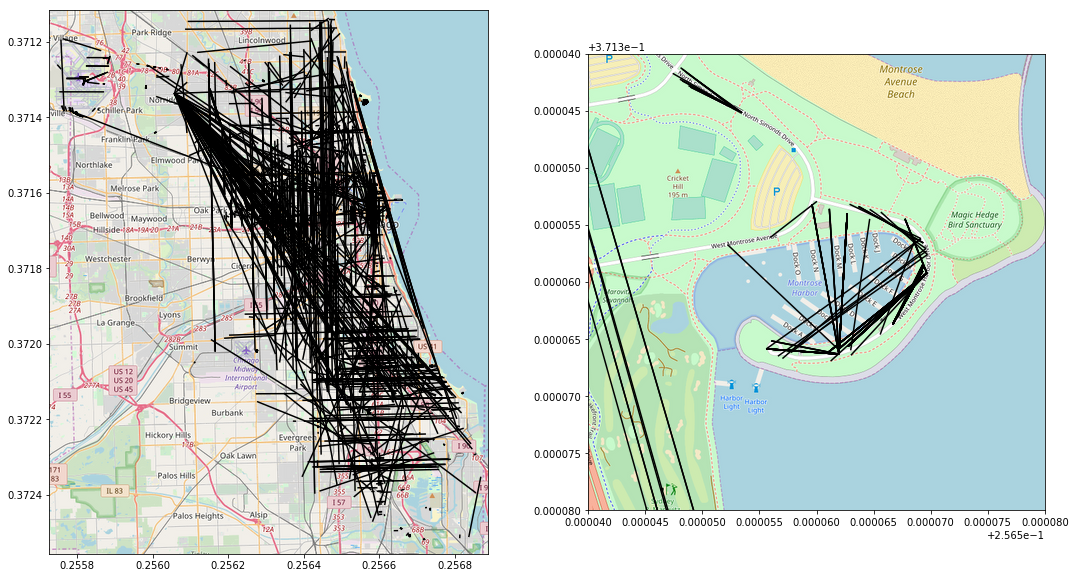

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

lines = []
m = raw_dists > 5
for x, y, xx, yy in zip(old_lon[m], old_lat[m], new_lon[m], new_lat[m]):
    x, y = tilemapbase.project(x, y)
    xx, yy = tilemapbase.project(xx, yy)
    lines.append( ((x,y), (xx, yy)) )

ex = tilemapbase.Extent.from_lonlat(lon_min-lon_d, lon_max+lon_d, lat_min-lat_d, lat_max+lat_d)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[0])
li = matplotlib.collections.LineCollection(lines, color="black")
ax[0].add_collection(li)

ex = tilemapbase.Extent.from_centre(0.25656, 0.37136, xsize=0.00004)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[1])
li = matplotlib.collections.LineCollection(lines, color="black")
ax[1].add_collection(li)

None

### Save to shapefile for viewing

- From browsing around in `QGIS` I am happy that all of these are a mixture of the two problems identified above.

In [7]:
import shapely.geometry
def to_dataframe(m):
    jumps = [row for row, want in zip(data, m) if want]
    frame = gpd.GeoDataFrame.from_dict({
        "code" : [row[0] for row in jumps],
        "date" : [row[1] for row in jumps],
        "address" : [row[2] for row in jumps],
        "type" : [row[3] for row in jumps],
        "sub-type" : [row[4] for row in jumps],
        "place" : [row[5] for row in jumps],
        })

    frame.geometry = [
        shapely.geometry.LineString([[float(row[7]), float(row[6])], [float(row[15]), float(row[14])]])
        for row, want in zip(data, m) if want]
    frame.crs={"init":"epsg:4326"}
    return frame

frame = to_dataframe(m)
len(frame)

2769

In [51]:
frame.to_file("jumps")

## Visualise the smaller jumps

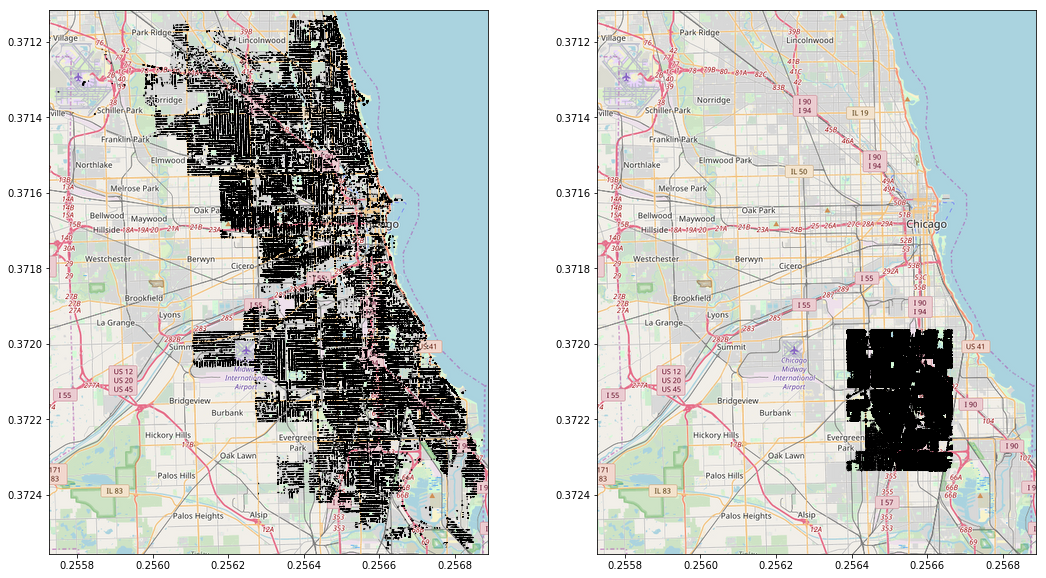

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

lines = []
m = (raw_dists < 5) & (raw_dists > 4)
for x, y, xx, yy in zip(old_lon[m], old_lat[m], new_lon[m], new_lat[m]):
    x, y = tilemapbase.project(x, y)
    xx, yy = tilemapbase.project(xx, yy)
    lines.append( ((x,y), (xx, yy)) )

ex = tilemapbase.Extent.from_lonlat(lon_min-lon_d, lon_max+lon_d, lat_min-lat_d, lat_max+lat_d)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[0])
li = matplotlib.collections.LineCollection(lines, color="black")
ax[0].add_collection(li)

lines = []
m = (raw_dists < 5) & (old_lon > -87.7) & (old_lon < -87.6) & (old_lat > 41.7) & (old_lat < 41.8)
for x, y, xx, yy in zip(old_lon[m], old_lat[m], new_lon[m], new_lat[m]):
    x, y = tilemapbase.project(x, y)
    xx, yy = tilemapbase.project(xx, yy)
    lines.append( ((x,y), (xx, yy)) )

#ex = tilemapbase.Extent.from_centre(0.2565, 0.3721, xsize=0.0001)
ex = tilemapbase.Extent.from_lonlat(lon_min-lon_d, lon_max+lon_d, lat_min-lat_d, lat_max+lat_d)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[1])
li = matplotlib.collections.LineCollection(lines, color="black")
ax[1].add_collection(li)

None

In [9]:
frame = to_dataframe(m)
len(frame)

1093793

In [85]:
frame.to_file("section")

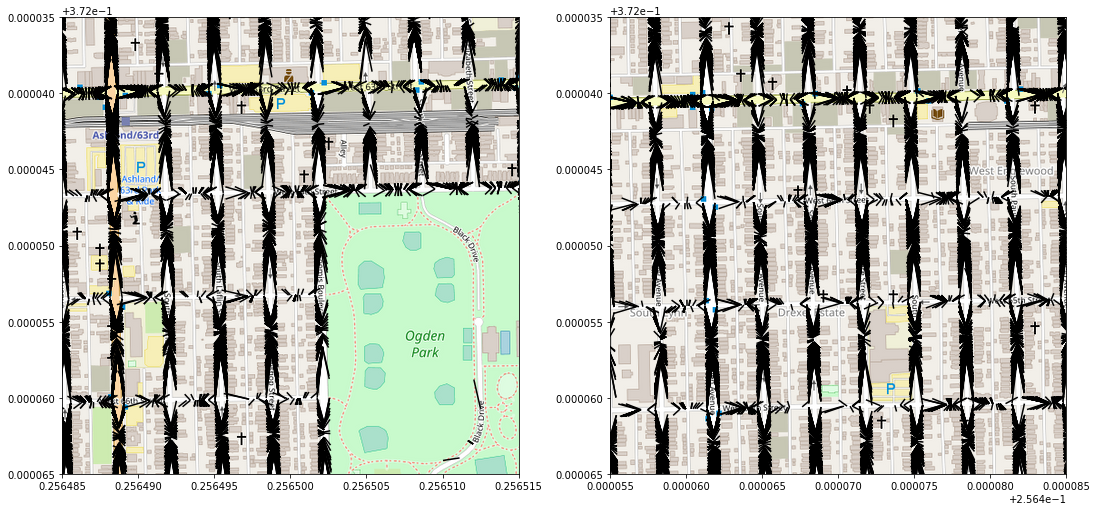

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

ex = tilemapbase.Extent.from_centre(0.2565, 0.37205, xsize=0.00003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[0])
ax[0].add_collection(matplotlib.collections.LineCollection(lines, color="black"))

ex = tilemapbase.Extent.from_centre(0.25647, 0.37205, xsize=0.00003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[1])
ax[1].add_collection(matplotlib.collections.LineCollection(lines, color="black"))

None

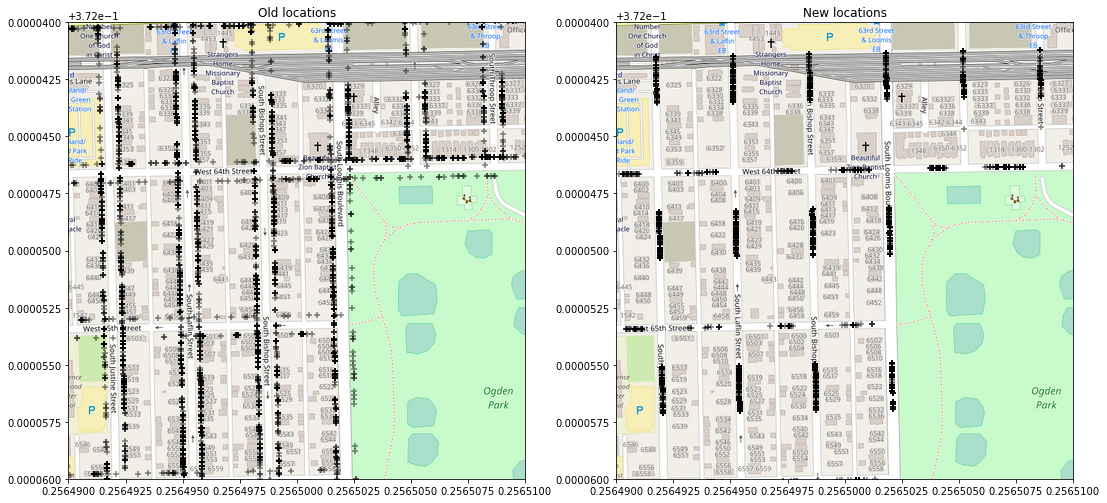

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

ex = tilemapbase.Extent.from_centre(0.2565, 0.37205, xsize=0.00002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)
plotter.plot(ax[0])

xx, yy = [], []
for x, y in zip(old_lon[m], old_lat[m]):
    x, y = tilemapbase.project(x, y)
    xx.append(x)
    yy.append(y)
ax[0].scatter(xx, yy, marker="+", color="black", alpha=0.5)
ax[0].set_title("Old locations")

plotter.plot(ax[1])
xx, yy = [], []
for x, y in zip(new_lon[m], new_lat[m]):
    x, y = tilemapbase.project(x, y)
    xx.append(x)
    yy.append(y)
ax[1].scatter(xx, yy, marker="+", color="black", alpha=0.5)
ax[1].set_title("New locations")

None

From browsing around with QGIS, the above plot looks representative of the general case:

- The old locations are always either side of the road.  Where there are buildings, the locations _do_ seem to correspond to the _likely entrance position_ of the building.  (But read the next few notes!)
- We should be aware that not all locations are accurate.  Events which occur at the location "SIDEWALK" (such as drug offenses, assult, or vehicle crime) are still geo-coded in the same way, off the road.
- Similarly, we can see in the above example that events which occured in the park are geocoded to a location just off the road.  Some of these are events which occured in the street.  Many occurred in the park.
- Some events whose "location" field suggest that the event occurred in the park are geocoded to the other side of the street.
- The more I look closely in QGIS, the less I believe that the geocoding is accurate to building level.  If you plot against a satelite overview, then there's not really any correlation.

By contrast, the new locations are always in the middle of the corresponding road.
- They also seem to be "clumpy": they occupy maybe 1/3 of the street, and _not_ the middle third.
- The mapping from the old locations to the new locations follows a very particular pattern.

I used to believe that the "old" locations were "accurate" (to address level, say).
- Now I am really not so sure.

In [18]:
loomis = [row for row in data if "064XX S LOOMIS BLVD" == row[2]]

In [26]:
frame = pd.DataFrame({
    "Case Number" : [row[0] for row in loomis],
    "Date" : [row[1] for row in loomis],
    "Block" : [row[2] for row in loomis],
    "Primary Type" : [row[3] for row in loomis],
    "Description" : [row[4] for row in loomis],
    "Location Description" : [row[5] for row in loomis]
})
frame.head()

Block Case Number                    Date       Description  \
0  064XX S LOOMIS BLVD    HX270691  05/21/2014 01:40:00 PM    $500 AND UNDER   
1  064XX S LOOMIS BLVD    HX238367  04/26/2014 03:32:00 PM  TELEPHONE THREAT   
2  064XX S LOOMIS BLVD    HX236071  04/24/2014 08:15:00 PM            SIMPLE   
3  064XX S LOOMIS BLVD    HX209368  04/03/2014 09:00:00 AM     FROM BUILDING   
4  064XX S LOOMIS BLVD    HX183756  03/13/2014 07:30:00 PM     FROM BUILDING   

  Location Description   Primary Type  
0            RESIDENCE          THEFT  
1            APARTMENT  OTHER OFFENSE  
2               STREET        BATTERY  
3            RESIDENCE          THEFT  
4            RESIDENCE          THEFT

In [28]:
frame.to_csv("loomis.csv")

# Conclusions

I now don't really believe the geo-coding of _either_ the "old" nor "new" datasets.

- The best we can say, I think, is that the block level address is correct, and the geo-coding corresponds to the correct block
- But any variation within that street segment should be regarded as random noise.